# Pixel classification
* update: 04/22/2020
* by Mike Chien-Cheng Shih

In [1]:
import os, sys
import itertools
import numpy as np

# image
from imutils import paths
import cv2
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk

# figure
import matplotlib.pyplot as plt

# metadata
import uuid
import json
from pprint import pprint
from datetime import datetime

# tensorboard
from tensorboard.plugins.hparams import api as hp

# customized function
from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.mlseg import create_training_dataset, create_binary_pattern, create_predict_dataset

from numpy.lib import stride_tricks
import mahotas as mt
import time
import pickle as pkl
import progressbar
import argparse
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm.notebook import trange, tqdm
from tqdm import tnrange, tqdm_notebook

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%load_ext autoreload
%autoreload 2

In [2]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# input set
# crop_input_set = '2020_01_23_09_51_20x'
crop_input_set = '2020_05_05_13_08_20x' # small training set

imginput = os.path.join('dl_seg_project_raw', 'data_crop', crop_input_set,)
imgpath = os.path.join(path, imginput)

print('input imgpath: {}'.format(imgpath))

img_dir = os.path.join(imgpath, 'images')
label_dir = os.path.join(imgpath, 'labels')

print('image dir: {}'.format(img_dir))
print('label dir: {}'.format(label_dir))

# create input file list
imgpath_all = list(paths.list_images(img_dir))
labelpath_all = list(paths.list_images(label_dir))

Load Images...
input imgpath: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_05_05_13_08_20x
image dir: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_05_05_13_08_20x\images
label dir: D:PerlmutterData\dl_seg_project_raw\data_crop\2020_05_05_13_08_20x\labels


In [3]:
print(imgpath_all[0])
print(len(imgpath_all))
print(labelpath_all[0])
print(len(labelpath_all))

D:PerlmutterData\dl_seg_project_raw\data_crop\2020_05_05_13_08_20x\images\nucleus\0001.tif
6620
D:PerlmutterData\dl_seg_project_raw\data_crop\2020_05_05_13_08_20x\labels\nucleus\0001.tif
6620


In [4]:
# create subset
subset_count = len(imgpath_all)
imgpath_all = imgpath_all[:subset_count]
labelpath_all = labelpath_all[:subset_count]

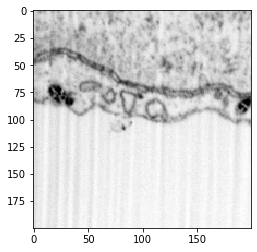

In [5]:
img_tmp = imread(imgpath_all[0], as_gray = True)
plt.imshow(img_tmp, cmap='gray')

(200, 200, 6620)



[[201 198 189 ... 183 162 168]
 [201 201 195 ... 189 177 171]
 [192 192 192 ... 180 180 171]
 ...
 [204 207 207 ... 228 225 228]
 [207 207 213 ... 231 231 222]
 [204 201 204 ... 225 225 228]]


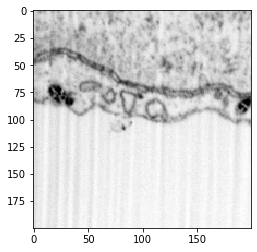

In [6]:
z = len(imgpath_all)
y, x = img_tmp.shape

# load image
img_stack = np.empty([y, x, z], dtype = 'uint8')
print(img_stack.shape)
for idx in tqdm(range(len(imgpath_all))):
    filepath = imgpath_all[idx]
    img_stack[:, :, idx] = np.uint8(imread(filepath, as_gray = True))
plt.imshow(img_stack[:, :, 0], cmap='gray')
print(img_stack[:, :, 0])

(200, 200, 6620)



[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


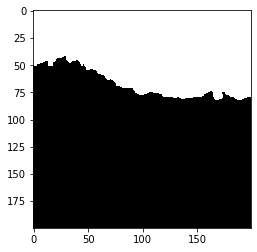

In [7]:
# load label
label_stack = np.empty([y, x, z], dtype = 'uint8')
print(label_stack.shape)
for idx in tqdm(range(len(labelpath_all))):
    filepath = labelpath_all[idx]
    img_tmp = imread(filepath, as_gray = True)
    img_tmp[img_tmp > 0] = 1
    
    if img_tmp.shape[0] == 200 and img_tmp.shape[1] == 200:
        label_stack[:, :, idx] = img_tmp
    else:
        print(filepath)
        break
    
plt.imshow(label_stack[:, :, 0], cmap='gray')
print(label_stack[:, :, 0])

In [8]:
n_samples = (label_stack > 0).sum()
print(n_samples)

85925952


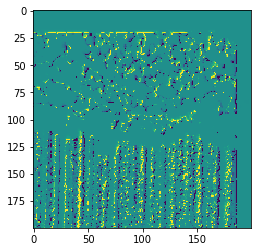

In [9]:
lbp_radius = 24
lbp_points = lbp_radius * 8

img_lbp = create_binary_pattern(img_stack[:, :, 0], lbp_points, lbp_radius)
plt.imshow(img_lbp)

In [34]:
def train_model(X, y, classifier):

    if classifier == "SVM":
        print ('Training Support Vector Machine model')
        model = SVC()
        model.fit(X, y)
    elif classifier == "RF":
        print ('Training Random Forest model')
        model = RandomForestClassifier(n_estimators=500, max_depth=12, random_state=50)
        model.fit(X, y)

    print('Model training complete.')
    print('Training Accuracy: %.2f' %model.score(X, y))
    return model

In [35]:
def test_model(X, y, model):

    pred = model.predict(X)
    accuracy = metrics.accuracy_score(y, pred)
    precision = metrics.precision_score(y, pred, average='weighted', labels=np.unique(pred))
    recall = metrics.recall_score(y, pred, average='weighted', labels=np.unique(pred))
    f1 = metrics.f1_score(y, pred, average='weighted', labels=np.unique(pred))

    print('--------------------------------')
    print('Results')
    print('Accuracy: %.2f' %accuracy)
    print('Precision: %.2f' %precision)
    print('Recall: %.2f' %recall)
    print('F1: %.2f' %f1)
    print('--------------------------------')

    return pred

In [36]:
import h5py

start = time.time()

# Prepare data
ml_path = os.path.join('D:', 'PerlmutterData', 'ML_methods', 'customized_ml', 'cache')

filelist = os.listdir(ml_path)
print(filelist)

cache_filename = 'cache_' + str(subset_count) + '.h5'

if not cache_filename in filelist:
    print('{} does not exist.'.format(cache_filename))
    X, y = create_training_dataset(img_stack, label_stack, num_examples = 20)
    
    # save cache in HDF5 format
    with h5py.File(os.path.join(ml_path, cache_filename), "w") as file:
        file.create_dataset('X', data=X)
        file.create_dataset('y', data=y)
else: 
    with h5py.File(os.path.join(ml_path, cache_filename), 'r') as file:
        print(type(file))
        X = file['X'][:]
        y = file['y'][:]

['cache_6620.h5']
<class 'h5py._hl.files.File'>


In [37]:
print(X.shape)
print(y.shape)

(6620, 20, 11)
(6620, 20, 1)


In [38]:
classifier = 'RF'

# Split training dataset
X = np.array(X)
X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
y = np.array(y)
y = y.reshape(y.shape[0]*y.shape[1], y.shape[2]).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Feature vector size: {}'.format(X_train.shape))

# trian model
model = train_model(X_train, y_train, classifier)

# save model
output_model = 'data_' + classifier + '.pkl'
pkl.dump(model, open(output_model, "wb"))

# test model
pred = test_model(X_test, y_test, model)

print ('Processing time:',time.time()-start)


Feature vector size: (105920, 11)
Training Random Forest model
Model training complete.
Training Accuracy: 0.84
--------------------------------
Results
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1: 0.81
--------------------------------
Processing time: 162.07981252670288


Creating predict dataset
Amount of images: 1


(200, 200, 2)
(190, 190, 2)


(36100, 11)

(36100, 11)
(36100,)


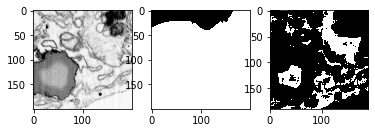

In [26]:
test_img = img_stack[:, :, 9]
test_img = test_img.reshape(200, 200, 1)
X = create_predict_dataset(test_img)
print(X.shape)
pred = model.predict(X)
print(pred.shape)
pred_img = pred.reshape(190, 190)


plt.subplot(131)
plt.imshow(test_img[:, :, 0], cmap=plt.cm.Greys_r)
plt.subplot(132)
plt.imshow(label_stack[:, :, 30], cmap=plt.cm.Greys_r)
plt.subplot(133)
plt.imshow(pred_img, cmap=plt.cm.Greys_r)

plt.show()

(36100,)


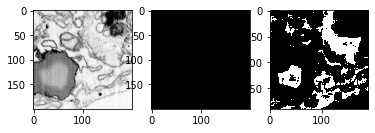

In [28]:
pred = model.predict(X)
print(pred.shape)
pred_img = pred.reshape(190, 190)


plt.subplot(131)
plt.imshow(test_img[:, :, 0], cmap=plt.cm.Greys_r)
plt.subplot(132)
plt.imshow(label_stack[:, :, 9], cmap=plt.cm.Greys_r)
plt.subplot(133)
plt.imshow(pred_img, cmap=plt.cm.Greys_r)

plt.show()